# Modeling for Income Prediction Data

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool

import optuna
from optuna.samplers import TPESampler

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import TargetEncoder

from xgboost import plot_importance

import warnings
warnings.filterwarnings(action='ignore')

In [6]:
# 데이터 경로
# path = "data/cramer_preprocessed.csv"
path = "data/cramer_preprocessed2.csv"
submission_path = "data/sample_submission.csv"
df = pd.read_csv(path)
submission_df = pd.read_csv(submission_path)

In [7]:
# 전체 컬럼 개수 : 12
len(df.columns)

9

## 데이터 분리

In [8]:
# concat 했던 train, test 데이터셋 분리
train = df.loc[:19999]
test = df.loc[20000:]
train.shape, test.shape

((20000, 9), (10000, 9))

In [9]:
# target 컬럼 "income"
target = "income"
# 나머지 컬럼 features에 선언
features = df.drop(columns=target).columns

# validation 데이터셋 생성
train, val = train_test_split(train, train_size=0.7, random_state=42)

In [10]:
# train 데이터 나눠준다
X_train = train[features]
y_train = train[target]

# validation 데이터 나눠준다
X_val = val[features]
y_val = val[target]

# test 데이터 나눠준다
X_test = test[features]
y_test = test[target]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((14000, 8), (14000,), (6000, 8), (6000,), (10000, 8), (10000,))

In [11]:
# train 데이터 copy
X_train_no_enc = train[features].copy()

# validation 데이터 copy
X_val_no_enc = val[features].copy()

# test 데이터 copy
X_test_no_enc = test[features].copy()

### Target Encoding
- 머신 러닝 모델의 출력이 숫자 (회귀)일 때만 범주형 feature에 사용

- 각 범주에 대한 평균 목표값 계산 → 인코딩 하기 위해 범주형 값이 갖는 범주에 해당하는 백분율 대체
- 각 카테고리의 값을 학습 데이터의 target 값의 평균값으로 설정한다
- 데이터 관측치가 많아야 한다
- 과적합의 원인이 될 수 있다
- references
    - https://conanmoon.medium.com/%EB%8D%B0%EC%9D%B4%ED%84%B0%EA%B3%BC%ED%95%99-%EC%9C%A0%EB%A7%9D%EC%A3%BC%EC%9D%98-%EB%A7%A4%EC%9D%BC-%EA%B8%80%EC%93%B0%EA%B8%B0-%EC%9D%BC%EA%B3%B1%EB%B2%88%EC%A7%B8-%EC%9D%BC%EC%9A%94%EC%9D%BC-7a40e7de39d4
    - https://velog.io/@seungwoong12/encoding

In [12]:
# Scikit-learn TargetEncoder 사용
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.TargetEncoder.html
# Scikit-learn 버전 높아야 사용 가능 (업데이트 필요)

# 범주형 변수 목록 cat_features에 선언
cat_features = df.select_dtypes(exclude=np.number).columns.tolist()

# smooth="auto", cv=5로 TargetEncoder 객체 생성
te = TargetEncoder(target_type="continuous", smooth="auto", cv=5, random_state=42)

for cat_feature in cat_features:
    # Train 데이터로 fit_transform 해준다
    X_train[[cat_feature]] = te.fit_transform(X_train[[cat_feature]], y_train)
    X_val[[cat_feature]] = te.transform(X_val[[cat_feature]])
    X_test[[cat_feature]] = te.transform(X_test[[cat_feature]])

## Baseline 모델 생성

In [13]:
# 선형회귀 모델로 Baseline 모델 생성
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [14]:
# Baseline 모델 절편, 결정 계수 확인

print("Intercept: ", lr.intercept_)
print("Coefficients:")
list(zip(X_train, lr.coef_))

Intercept:  -756.2797015423208
Coefficients:


[('age', 1.0912833591368167),
 ('gender', 0.5123106543033779),
 ('education_status', 0.08919140812102645),
 ('working_week (yearly)', 3.494596015609529),
 ('occupation_status', 0.7463709290031763),
 ('race', -0.27674943845372024),
 ('citizenship', 0.6066711045954585),
 ('income_status', 0.3894408936164236)]

In [15]:
def baseline_model(model_name, model):
    baseline_results = []

    print(f"\n====== Baseline Model : {model_name} ======")
    
    # 모델 생성 및 훈련
    # model.fit(X_train, y_train)

    # Baseline 모델로 train, validation, test 데이터셋 예측
    y_train_pred_lr = model.predict(X_train)
    y_val_pred_lr = model.predict(X_val)

    # Baseline 모델의 MAE, MSE, RMSE, RMSLE, R2 score 확인
    base_meanAbErr = metrics.mean_absolute_error(y_val, y_val_pred_lr)
    base_meanSqErr = metrics.mean_squared_error(y_val, y_val_pred_lr)
    base_rootMeanSqErr = metrics.mean_squared_error(y_val, y_val_pred_lr, squared=False)


    # 결과를 리스트에 저장
    baseline_results.append({"Model" : model_name,
                             "MAE" : '{:.2f}'.format(base_meanAbErr),
                             "MSE" : '{:.2f}'.format(base_meanSqErr),
                             "RMSE" : '{:.2f}'.format(base_rootMeanSqErr),
                             "R2 Score" : '{:.2f}'.format(model.score(X_val, y_val))})
    
    # 결과 리스트를 DataFrame으로 변환
    baseline_df = pd.DataFrame(baseline_results)
    
    return baseline_df

In [16]:
baseline_model("Linear Regression", lr)


====== Baseline Model : Linear Regression ======


,Model,MAE,MSE,RMSE,R2 Score
0,Linear Regression,369.32,362122.46,601.77,0.24


## 머신러닝 모델링

### 하이퍼 파라미터 튜닝 전 모델 생성

In [17]:
model_list = ["lr_model", "dt_model", "rf_model", "cat_model", "lgbm_model", "xgb_model"]

lr_model = LinearRegression()
dt_model = DecisionTreeRegressor(random_state=42)
rf_model = RandomForestRegressor(random_state=42)
cat_model = CatBoostRegressor(random_state=42)
lgbm_model = LGBMRegressor(random_state=42)
xgb_model = XGBRegressor(random_state=42)

models = [
    ("Linear Regression", LinearRegression()),
    ("Decision Tree", DecisionTreeRegressor(random_state=42)),
    ("Random Forest", RandomForestRegressor(random_state=42)),
    ("CatBoost", CatBoostRegressor(random_state=42)),
    ("LightGBM", LGBMRegressor(random_state=42)),
    ("XGBoost", XGBRegressor(random_state=42))
]

In [18]:
def model_list(models, when="Before"):
    models_results = []

    for model_name, model in models:

        # 모델 생성 및 훈련
        # 트리 기반 모델들은 각 변수의 information gain을 기반으로 판단하기 때문에 굳이 스케일링 해줄 필요가 없다

        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        # 모델의 MAE, MSE, RMSE, RMSLE, R2 score 확인
        meanAbErr = metrics.mean_absolute_error(y_val, y_val_pred)
        meanSqErr = metrics.mean_squared_error(y_val, y_val_pred)
        rootMeanSqErr = metrics.mean_squared_error(y_val, y_val_pred, squared=False)


        # 결과를 리스트에 저장
        models_results.append({"Model" : model_name,
                                "MAE" : '{:.2f}'.format(meanAbErr),
                                "MSE" : '{:.2f}'.format(meanSqErr),
                                "RMSE" : '{:.2f}'.format(rootMeanSqErr),
                                "R2 Score" : '{:.2f}'.format(model.score(X_val, y_val))})
    
    # 결과 리스트를 DataFrame으로 변환
    models_df = pd.DataFrame(models_results)

    print(f"\n====== Models {when} Hyper Parameter Tuning ======")
    
    return models_df.sort_values(by=["RMSE", "R2 Score"], ascending=[True, False]).reset_index(drop=True)

In [19]:
model_list(models)

Learning rate set to 0.062125
0:	learn: 696.1984370	total: 132ms	remaining: 2m 11s
1:	learn: 687.6941488	total: 134ms	remaining: 1m 6s
2:	learn: 679.5204331	total: 139ms	remaining: 46.3s
3:	learn: 672.4966889	total: 142ms	remaining: 35.4s
4:	learn: 666.0322854	total: 145ms	remaining: 28.9s
5:	learn: 660.1541103	total: 147ms	remaining: 24.4s
6:	learn: 655.2389873	total: 149ms	remaining: 21.2s
7:	learn: 650.7889245	total: 153ms	remaining: 19s
8:	learn: 646.3558390	total: 156ms	remaining: 17.1s
9:	learn: 642.8534138	total: 158ms	remaining: 15.7s
10:	learn: 639.2459343	total: 161ms	remaining: 14.4s
11:	learn: 636.2933012	total: 163ms	remaining: 13.4s
12:	learn: 633.3904007	total: 165ms	remaining: 12.5s
13:	learn: 630.8251095	total: 170ms	remaining: 11.9s
14:	learn: 628.7325627	total: 172ms	remaining: 11.3s
15:	learn: 626.6380121	total: 175ms	remaining: 10.7s
16:	learn: 624.7353844	total: 177ms	remaining: 10.2s
17:	learn: 623.0066791	total: 179ms	remaining: 9.78s
18:	learn: 621.7157585	tota

,Model,MAE,MSE,RMSE,R2 Score
0,LightGBM,348.21,356908.98,597.42,0.25
1,CatBoost,351.38,359368.06,599.47,0.25
2,Linear Regression,369.32,362122.46,601.77,0.24
3,XGBoost,364.40,384016.27,619.69,0.20
4,Random Forest,364.22,388117.58,622.99,0.19
5,Decision Tree,471.25,686457.93,828.53,-0.44


In [20]:
# 범주형 변수를 따로 Target Encoding 거치지 않은 데이터셋으로 학습한 CatBoost 확인
def model_list2(models, when="Before"):
    models_results = []

    for model_name, model in models:

        if model_name in ["CatBoost", "CatBoost_tuned"]:

            cat_features = X_train_no_enc.select_dtypes(exclude=np.number).columns.tolist()

            X_train_pool = Pool(data=X_train_no_enc, label=y_train, cat_features=cat_features)
            X_val_pool = Pool(data=X_val_no_enc, label=y_val, cat_features=cat_features)

            # 모델 생성 및 훈련
            model.fit(X_train_pool, eval_set=X_val_pool, use_best_model=True)

            # Robust Scaling 거치지 않은 train 데이터를 바탕으로 예측
            y_train_pred_cat = model.predict(X_train_no_enc)
            y_val_pred_cat = model.predict(X_val_no_enc)

            # 모델의 MAE, MSE, RMSE, RMSLE, R2 score 확인
            meanAbErr_cat = metrics.mean_absolute_error(y_val, y_val_pred_cat)
            meanSqErr_cat = metrics.mean_squared_error(y_val, y_val_pred_cat)
            rootMeanSqErr_cat = metrics.mean_squared_error(y_val, y_val_pred_cat, squared=False)

            # 결과를 리스트에 저장
            models_results.append({"Model" : model_name,
                                    "MAE" : '{:.2f}'.format(meanAbErr_cat),
                                    "MSE" : '{:.2f}'.format(meanSqErr_cat),
                                    "RMSE" : '{:.2f}'.format(rootMeanSqErr_cat),
                                    "R2 Score" : '{:.2f}'.format(model.score(X_val_no_enc, y_val))})
        
        else:
            
            # 모델 생성 및 훈련
            model.fit(X_train, y_train)

            y_train_pred = model.predict(X_train)
            y_val_pred = model.predict(X_val)

            # 모델의 MAE, MSE, RMSE, RMSLE, R2 score 확인
            meanAbErr = metrics.mean_absolute_error(y_val, y_val_pred)
            meanSqErr = metrics.mean_squared_error(y_val, y_val_pred)
            rootMeanSqErr = metrics.mean_squared_error(y_val, y_val_pred, squared=False)

            # 결과를 리스트에 저장
            models_results.append({"Model" : model_name,
                                    "MAE" : '{:.2f}'.format(meanAbErr),
                                    "MSE" : '{:.2f}'.format(meanSqErr),
                                    "RMSE" : '{:.2f}'.format(rootMeanSqErr),
                                    "R2 Score" : '{:.2f}'.format(model.score(X_val, y_val))})
    
    # 결과 리스트를 DataFrame으로 변환
    models_df = pd.DataFrame(models_results)

    print(f"\n====== Models {when} Hyper Parameter Tuning ======")
    
    return models_df.sort_values(by=["RMSE", "R2 Score"], ascending=[True, False]).reset_index(drop=True)

In [21]:
model_list2(models)

Learning rate set to 0.077062
0:	learn: 694.6403973	test: 678.8806802	best: 678.8806802 (0)	total: 49.6ms	remaining: 49.6s
1:	learn: 685.0658314	test: 668.7585680	best: 668.7585680 (1)	total: 150ms	remaining: 1m 14s
2:	learn: 676.7447190	test: 660.2196774	best: 660.2196774 (2)	total: 204ms	remaining: 1m 7s
3:	learn: 669.8256767	test: 653.0727263	best: 653.0727263 (3)	total: 240ms	remaining: 59.8s
4:	learn: 663.5761481	test: 646.5141536	best: 646.5141536 (4)	total: 300ms	remaining: 59.6s
5:	learn: 657.2273899	test: 640.0682965	best: 640.0682965 (5)	total: 352ms	remaining: 58.4s
6:	learn: 652.2105800	test: 634.8029965	best: 634.8029965 (6)	total: 400ms	remaining: 56.7s
7:	learn: 647.7688703	test: 630.2025885	best: 630.2025885 (7)	total: 453ms	remaining: 56.2s
8:	learn: 643.7066667	test: 626.2048115	best: 626.2048115 (8)	total: 502ms	remaining: 55.2s
9:	learn: 640.0659190	test: 622.5002479	best: 622.5002479 (9)	total: 552ms	remaining: 54.7s
10:	learn: 636.4856199	test: 619.0960348	best: 6

,Model,MAE,MSE,RMSE,R2 Score
0,CatBoost,346.94,353533.11,594.59,0.26
1,LightGBM,348.21,356908.98,597.42,0.25
2,Linear Regression,369.32,362122.46,601.77,0.24
3,XGBoost,364.40,384016.27,619.69,0.20
4,Random Forest,364.22,388117.58,622.99,0.19
5,Decision Tree,471.25,686457.93,828.53,-0.44


#### `CatBoost` 성능 비교
- 별도로 `Target Encoding` 거치지 않은 데이터셋으로 진행(`model_list2` 함수)한 `CatBoost`가 더 낮은 `RMSE` 기록

    - **596.14 vs 594.30** (CatBoost는 Target Encoding 실행하지 않은 데이터셋으로 진행)

### 하이퍼 파라미터 튜닝
- `RMSE`가 낮은 `CatBoost`, `LightGBM` 을 갖고 하이퍼 파라미터 튜닝
    - Baseline 모델인 `Linear Regression`의 `RMSE`보다 낮다 (599.30)
- `XGBoost`은 Baseline보다 `RMSE` 높지만 하이퍼파라이터 튜닝 시도

- `optuna` 활용
    - References : https://forecastegy.com/posts/xgboost-hyperparameter-tuning-with-optuna/


In [22]:
# optuna sampling seed 고정
sampler = TPESampler(seed=42)

#### CatBoost

In [23]:
def objective_cat(trial):
    params = {
        # "iterations": 1000,
        "iterations" : trial.suggest_int('n_estimators', 500, 4000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }
    cat_features = X_train_no_enc.select_dtypes(exclude=np.number).columns.tolist()

    X_train_pool = Pool(data=X_train_no_enc, label=y_train, cat_features=cat_features)
    X_val_pool = Pool(data=X_val_no_enc, label=y_val, cat_features=cat_features)

    model = CatBoostRegressor(**params, silent=True, random_state=42)
    model.fit(X_train_pool, eval_set=X_val_pool, use_best_model=True)
    predictions = model.predict(X_val_no_enc)
    rmse = metrics.mean_squared_error(y_val, predictions, squared=False)

    return rmse

In [24]:
study_cat = optuna.create_study(direction='minimize', sampler=sampler)
study_cat.optimize(objective_cat, n_trials=30)

[I 2024-04-08 03:01:14,011] A new study created in memory with name: no-name-dec63d18-4593-4974-8074-48040ceda90b
[I 2024-04-08 03:02:57,090] Trial 0 finished with value: 594.7390630126096 and parameters: {'n_estimators': 1811, 'learning_rate': 0.07969454818643935, 'depth': 8, 'subsample': 0.6187255599871848, 'colsample_bylevel': 0.19821770842031466, 'min_data_in_leaf': 16}. Best is trial 0 with value: 594.7390630126096.
[I 2024-04-08 03:03:05,152] Trial 1 finished with value: 594.50813030912 and parameters: {'n_estimators': 703, 'learning_rate': 0.05399484409787434, 'depth': 7, 'subsample': 0.7226689489062432, 'colsample_bylevel': 0.06955526958101232, 'min_data_in_leaf': 97}. Best is trial 1 with value: 594.50813030912.
[I 2024-04-08 03:04:09,692] Trial 2 finished with value: 597.1693587650393 and parameters: {'n_estimators': 3414, 'learning_rate': 0.0026587543983272706, 'depth': 2, 'subsample': 0.22423428436076215, 'colsample_bylevel': 0.3390301308115608, 'min_data_in_leaf': 53}. Bes

In [25]:
print("Best hyperparameters:", study_cat.best_params, sep="\n")
print("-----------------------------------------------------------------------------------------------------------------")
print("Best RMSE:", study_cat.best_value, sep="\n")

Best hyperparameters:
{'n_estimators': 2944, 'learning_rate': 0.020968730051235146, 'depth': 5, 'subsample': 0.933897138035344, 'colsample_bylevel': 0.1411156984351208, 'min_data_in_leaf': 43}
-----------------------------------------------------------------------------------------------------------------
Best RMSE:
594.0103412070268


In [26]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_cat)

In [27]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_cat)

In [28]:
cat_optuna = CatBoostRegressor(**study_cat.best_params)
model_list2([("CatBoost_tuned", cat_optuna)], "After")

0:	learn: 706.0379522	test: 690.9432347	best: 690.9432347 (0)	total: 2.6ms	remaining: 7.64s
1:	learn: 702.9578585	test: 687.7220526	best: 687.7220526 (1)	total: 29.3ms	remaining: 43s
2:	learn: 700.3065529	test: 684.9935676	best: 684.9935676 (2)	total: 67.2ms	remaining: 1m 5s
3:	learn: 700.3065529	test: 684.9935619	best: 684.9935619 (3)	total: 69.3ms	remaining: 50.9s
4:	learn: 697.8765875	test: 682.4510722	best: 682.4510722 (4)	total: 116ms	remaining: 1m 7s
5:	learn: 697.8765875	test: 682.4510653	best: 682.4510653 (5)	total: 118ms	remaining: 57.6s
6:	learn: 697.8765875	test: 682.4510585	best: 682.4510585 (6)	total: 120ms	remaining: 50.1s
7:	learn: 695.0510156	test: 679.5624168	best: 679.5624168 (7)	total: 151ms	remaining: 55.5s
8:	learn: 692.6703909	test: 677.1204382	best: 677.1204382 (8)	total: 236ms	remaining: 1m 16s
9:	learn: 690.1480784	test: 674.4766679	best: 674.4766679 (9)	total: 304ms	remaining: 1m 29s
10:	learn: 690.1480784	test: 674.4766558	best: 674.4766558 (10)	total: 306ms	

24:	learn: 671.7702860	test: 655.3329863	best: 655.3329863 (24)	total: 664ms	remaining: 1m 17s
25:	learn: 670.1225300	test: 653.6249809	best: 653.6249809 (25)	total: 697ms	remaining: 1m 18s
26:	learn: 668.4400189	test: 651.8532561	best: 651.8532561 (26)	total: 752ms	remaining: 1m 21s
27:	learn: 667.7558735	test: 651.1653076	best: 651.1653076 (27)	total: 783ms	remaining: 1m 21s
28:	learn: 665.9789399	test: 649.3707403	best: 649.3707403 (28)	total: 829ms	remaining: 1m 23s
29:	learn: 665.9789397	test: 649.3707182	best: 649.3707182 (29)	total: 830ms	remaining: 1m 20s
30:	learn: 664.2940146	test: 647.6832076	best: 647.6832076 (30)	total: 866ms	remaining: 1m 21s
31:	learn: 663.7370862	test: 647.1320568	best: 647.1320568 (31)	total: 867ms	remaining: 1m 18s
32:	learn: 662.3355226	test: 645.6742187	best: 645.6742187 (32)	total: 893ms	remaining: 1m 18s
33:	learn: 662.3355224	test: 645.6741942	best: 645.6741942 (33)	total: 896ms	remaining: 1m 16s
34:	learn: 661.6846415	test: 645.0471227	best: 645

,Model,MAE,MSE,RMSE,R2 Score
0,CatBoost_tuned,347.13,352094.20,593.38,0.26


#### LightGBM

In [29]:
def objective_lgbm(trial):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "n_estimators": trial.suggest_int('n_estimators', 500, 4000),
        "verbosity": -1,
        "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = LGBMRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    rmse = metrics.mean_squared_error(y_val, predictions, squared=False)


    return rmse

In [30]:
study_lgbm = optuna.create_study(direction='minimize', sampler=sampler)
study_lgbm.optimize(objective_lgbm, n_trials=30)

[I 2024-04-08 03:39:00,660] A new study created in memory with name: no-name-eea822b9-985f-4576-86c6-a7f88bc283ad


[I 2024-04-08 03:39:07,192] Trial 0 finished with value: 595.1188149823512 and parameters: {'n_estimators': 1860, 'learning_rate': 0.003488976654890368, 'num_leaves': 849, 'subsample': 0.3889156603589098, 'colsample_bytree': 0.3168877842030117, 'min_data_in_leaf': 55}. Best is trial 0 with value: 595.1188149823512.
[I 2024-04-08 03:39:11,022] Trial 1 finished with value: 618.8695351896355 and parameters: {'n_estimators': 993, 'learning_rate': 0.040215545266902894, 'num_leaves': 78, 'subsample': 0.9875425897704915, 'colsample_bytree': 0.7836325308318246, 'min_data_in_leaf': 20}. Best is trial 0 with value: 595.1188149823512.
[I 2024-04-08 03:39:27,528] Trial 2 finished with value: 639.8538143748842 and parameters: {'n_estimators': 519, 'learning_rate': 0.04274869455295218, 'num_leaves': 725, 'subsample': 0.742556809638938, 'colsample_bytree': 0.7827068293516485, 'min_data_in_leaf': 8}. Best is trial 0 with value: 595.1188149823512.
[I 2024-04-08 03:39:58,220] Trial 3 finished with value

In [31]:
print("Best hyperparameters:", study_lgbm.best_params, sep="\n")
print("-----------------------------------------------------------------------------------------------------------------")
print("Best RMSE:", study_lgbm.best_value, sep="\n")

Best hyperparameters:
{'n_estimators': 1083, 'learning_rate': 0.0029342254653003737, 'num_leaves': 121, 'subsample': 0.1894681671988927, 'colsample_bytree': 0.7233930021860604, 'min_data_in_leaf': 47}
-----------------------------------------------------------------------------------------------------------------
Best RMSE:
594.2179891601535


In [32]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_lgbm)

In [33]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_lgbm)

In [34]:
lgbm_optuna = LGBMRegressor(**study_lgbm.best_params)
model_list2([("LightGBM_tuned", lgbm_optuna)], "After")

[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 350
[LightGBM] [Info] Number of data points in the train set: 14000, number of used features: 8
[LightGBM] [Info] Start training from score 557.920714


[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47

====== Models After Hyper Parameter Tuning ======


,Model,MAE,MSE,RMSE,R2 Score
0,LightGBM_tuned,353.37,356542.98,597.11,0.25


#### XGBoost

In [35]:
def objective_xgb(trial):
    params = {
        "objective": "reg:squarederror",
        "n_estimators" : trial.suggest_int('n_estimators', 500, 4000),
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }

    model = XGBRegressor(**params, random_state=42)
    model.fit(X_train, y_train, verbose=False)
    predictions = model.predict(X_val)
    rmse = metrics.mean_squared_error(y_val, predictions, squared=False)

    return rmse

In [36]:
study_xgb = optuna.create_study(direction='minimize', sampler=sampler)
study_xgb.optimize(objective_xgb, n_trials=30)

[I 2024-04-08 03:42:34,078] A new study created in memory with name: no-name-fa1e8e78-1adb-4c75-a073-f040da4a62bc
[I 2024-04-08 03:42:43,131] Trial 0 finished with value: 614.9197489594271 and parameters: {'n_estimators': 3326, 'learning_rate': 0.06197015748809146, 'max_depth': 4, 'subsample': 0.15454932830129292, 'colsample_bytree': 0.2665384044148446, 'min_child_weight': 9}. Best is trial 0 with value: 614.9197489594271.
[I 2024-04-08 03:42:47,922] Trial 1 finished with value: 597.9745984068117 and parameters: {'n_estimators': 3363, 'learning_rate': 0.05265761277157429, 'max_depth': 1, 'subsample': 0.5352099374486874, 'colsample_bytree': 0.44654045299134, 'min_child_weight': 5}. Best is trial 1 with value: 597.9745984068117.
[I 2024-04-08 03:42:54,396] Trial 2 finished with value: 594.6564802358798 and parameters: {'n_estimators': 919, 'learning_rate': 0.0047340227734041914, 'max_depth': 10, 'subsample': 0.35704278541971746, 'colsample_bytree': 0.5428510906561977, 'min_child_weight':

In [37]:
print("Best hyperparameters:", study_xgb.best_params, sep="\n")
print("-----------------------------------------------------------------------------------------------------------------")
print("Best RMSE:", study_xgb.best_value, sep="\n")

Best hyperparameters:
{'n_estimators': 1852, 'learning_rate': 0.0030371194606465825, 'max_depth': 5, 'subsample': 0.46854315835618865, 'colsample_bytree': 0.6218549722312963, 'min_child_weight': 13}
-----------------------------------------------------------------------------------------------------------------
Best RMSE:
594.334355954612


In [38]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_xgb)

In [39]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_xgb)

In [40]:
xgb_optuna = XGBRegressor(**study_xgb.best_params)
model_list2([("XGBoost_tuned", xgb_optuna)], "After")


====== Models After Hyper Parameter Tuning ======


,Model,MAE,MSE,RMSE,R2 Score
0,XGBoost_tuned,351.38,353430.51,594.50,0.26


#### 튜닝한 모델들 비교

In [41]:
models_tuned = models = [
    ("CatBoost_tuned", cat_optuna),
    ("LightGBM_tuned", lgbm_optuna),
    ("XGBoost_tuned", xgb_optuna)
]

In [42]:
model_list2(models_tuned, "After")

0:	learn: 706.0379522	test: 690.9432347	best: 690.9432347 (0)	total: 3.79ms	remaining: 11.2s
1:	learn: 702.9578585	test: 687.7220526	best: 687.7220526 (1)	total: 12ms	remaining: 17.7s
2:	learn: 700.3065529	test: 684.9935676	best: 684.9935676 (2)	total: 54.3ms	remaining: 53.2s
3:	learn: 700.3065529	test: 684.9935619	best: 684.9935619 (3)	total: 56.5ms	remaining: 41.5s
4:	learn: 697.8765875	test: 682.4510722	best: 682.4510722 (4)	total: 89.5ms	remaining: 52.6s
5:	learn: 697.8765875	test: 682.4510653	best: 682.4510653 (5)	total: 91.7ms	remaining: 44.9s
6:	learn: 697.8765875	test: 682.4510585	best: 682.4510585 (6)	total: 93.4ms	remaining: 39.2s
7:	learn: 695.0510156	test: 679.5624168	best: 679.5624168 (7)	total: 123ms	remaining: 45.2s
8:	learn: 692.6703909	test: 677.1204382	best: 677.1204382 (8)	total: 163ms	remaining: 53.2s


9:	learn: 690.1480784	test: 674.4766679	best: 674.4766679 (9)	total: 211ms	remaining: 1m 1s
10:	learn: 690.1480784	test: 674.4766558	best: 674.4766558 (10)	total: 214ms	remaining: 57.1s
11:	learn: 689.2618652	test: 673.5518348	best: 673.5518348 (11)	total: 226ms	remaining: 55.3s
12:	learn: 686.9336111	test: 671.0733056	best: 671.0733056 (12)	total: 258ms	remaining: 58.2s
13:	learn: 684.8107602	test: 668.8781593	best: 668.8781593 (13)	total: 276ms	remaining: 57.7s
14:	learn: 682.4786530	test: 666.4673446	best: 666.4673446 (14)	total: 339ms	remaining: 1m 6s
15:	learn: 681.5967973	test: 665.5725436	best: 665.5725436 (15)	total: 358ms	remaining: 1m 5s
16:	learn: 681.5967972	test: 665.5725304	best: 665.5725304 (16)	total: 360ms	remaining: 1m 2s
17:	learn: 679.7750038	test: 663.6501313	best: 663.6501313 (17)	total: 390ms	remaining: 1m 3s
18:	learn: 677.8582656	test: 661.6582377	best: 661.6582377 (18)	total: 407ms	remaining: 1m 2s
19:	learn: 675.8309909	test: 659.4880212	best: 659.4880212 (19

,Model,MAE,MSE,RMSE,R2 Score
0,CatBoost_tuned,347.13,352094.20,593.38,0.26
1,XGBoost_tuned,351.38,353430.51,594.50,0.26
2,LightGBM_tuned,353.37,356542.98,597.11,0.25


#### 모델별 최적의 하이퍼파라미터

In [43]:
best_params_cat = {'n_estimators': 3109, 
                   'learning_rate': 0.0038837130871997557, 
                   'depth': 7, 
                   'subsample': 0.37565932385300044, 
                   'colsample_bylevel': 0.45813385565498144, 
                   'min_data_in_leaf': 28}

best_params_xgb = {'n_estimators': 2515, 
                   'learning_rate': 0.002207946294234413, 
                   'max_depth': 6, 
                   'subsample': 0.4745042707478379, 
                   'colsample_bytree': 0.6978452312043825, 
                   'min_child_weight': 20}

best_params_lgbm = {'n_estimators': 3601, 
                    'learning_rate': 0.0011201643796082707, 
                    'num_leaves': 184, 
                    'subsample': 0.2970900102311786, 
                    'colsample_bytree': 0.43170716684320626, 
                    'min_data_in_leaf': 29}


## 최적화 후 모델 재생성
- `XGBoost` : 가장 작은 RMSE 기록
    - RMSE : 593.38
    - R2 Score : 0.26
- `CatBoost` : 2번째로 작은 RMSE 기록
    - RMSE : 593.44
    - R2 Score : 0.26

### XGBoost

In [44]:
# optuna를 통해 생성한 하이퍼 파라미터로 조정하여, xgb 모델 생성
xgb_optuna.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6218549722312963, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0030371194606465825,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=13, missing=nan, monotone_constraints=None,
             n_estimators=1852, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [45]:
rmse_xgb = metrics.mean_squared_error(y_val, xgb_optuna.predict(X_val),squared=False)
rmse_xgb

594.5002149130124

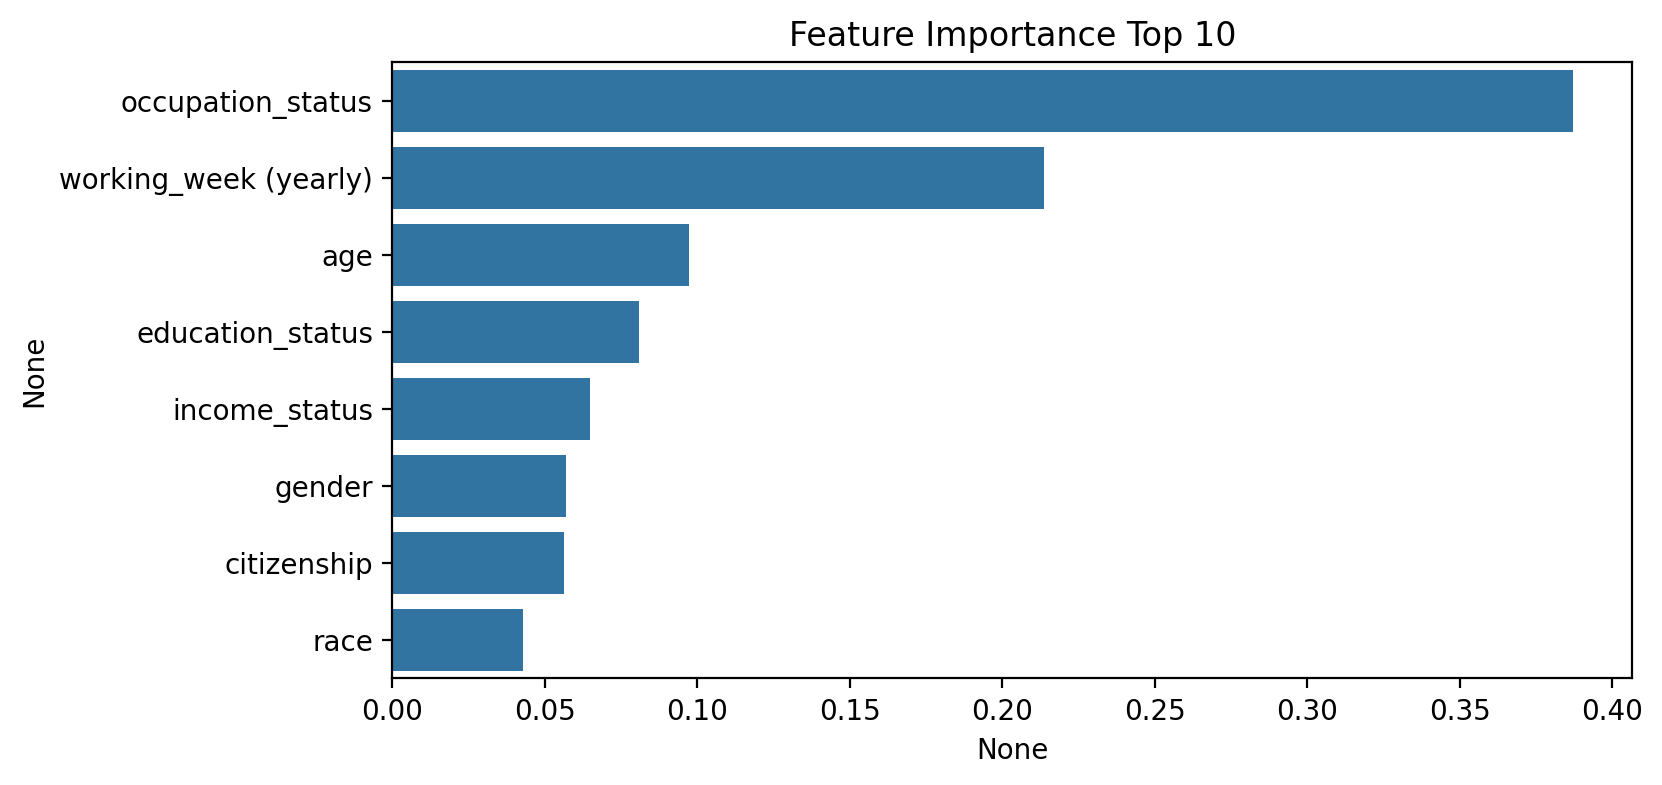

In [46]:
# feature importance 파악

# 배열형태로 반환
xgb_importance_values = xgb_optuna.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
xgb_series = pd.Series(xgb_importance_values, index = X_train.columns)
xgb_top10 = xgb_series.sort_values(ascending=False)[:10]

# 시각화
plt.figure(figsize=(8,4))
plt.title('Feature Importance Top 10')
sns.barplot(x=xgb_top10, y=xgb_top10.index)
plt.show()


# 이 지표는 절대적이지 않다.
# 중요도는 낮게 평가되었지만 실제로 중요한 특성일 수도 있고,
# 그렇기 때문에 제거했을 경우 성능이 떨어질 수도 있다.
# -> 상위 n개의 특성들을 제외한 나머지 특성들을 모두 제거하는 방식은 바람직하지 못함

# feature importance를 고려하여 특성별로 A/B test 를 진행하며 feature selection 해야 한다
# https://hwi-doc.tistory.com/entry/Feature-selection-feature-importance-vs-permutation-importance

In [47]:
y_test_xgb = xgb_optuna.predict(X_test)
y_test_xgb

array([ -2.3848588,  27.990593 , 457.56973  , ..., 557.9715   ,
        -2.83736  , 674.8328   ], dtype=float32)

In [48]:
submission_df_xgb = submission_df.copy()
submission_df_xgb["Income"] = y_test_xgb
submission_df_xgb.head()

,ID,Income
0,TEST_0000,-2.384859
1,TEST_0001,27.990593
2,TEST_0002,457.569733
3,TEST_0003,519.655579
4,TEST_0004,-1.441910


In [49]:
# 전처리 완료한 파일 csv로 저장
submission_df_xgb.to_csv("data/submission_xgb3.csv", index=False)

### CatBoost

In [50]:
# optuna를 통해 생성한 하이퍼 파라미터로 조정하여, CatBoost 모델 생성
cat_features = X_train_no_enc.select_dtypes(exclude=np.number).columns.tolist()

X_train_pool = Pool(data=X_train_no_enc, label=y_train, cat_features=cat_features)
X_val_pool = Pool(data=X_val_no_enc, label=y_val, cat_features=cat_features)

cat_optuna.fit(X_train_pool, eval_set=X_val_pool, use_best_model=True)

0:	learn: 706.0379522	test: 690.9432347	best: 690.9432347 (0)	total: 3.44ms	remaining: 10.1s
1:	learn: 702.9578585	test: 687.7220526	best: 687.7220526 (1)	total: 15.4ms	remaining: 22.6s
2:	learn: 700.3065529	test: 684.9935676	best: 684.9935676 (2)	total: 48.6ms	remaining: 47.6s
3:	learn: 700.3065529	test: 684.9935619	best: 684.9935619 (3)	total: 50.7ms	remaining: 37.3s
4:	learn: 697.8765875	test: 682.4510722	best: 682.4510722 (4)	total: 83.9ms	remaining: 49.3s
5:	learn: 697.8765875	test: 682.4510653	best: 682.4510653 (5)	total: 85.7ms	remaining: 42s
6:	learn: 697.8765875	test: 682.4510585	best: 682.4510585 (6)	total: 87.7ms	remaining: 36.8s
7:	learn: 695.0510156	test: 679.5624168	best: 679.5624168 (7)	total: 137ms	remaining: 50.2s
8:	learn: 692.6703909	test: 677.1204382	best: 677.1204382 (8)	total: 214ms	remaining: 1m 9s
9:	learn: 690.1480784	test: 674.4766679	best: 674.4766679 (9)	total: 298ms	remaining: 1m 27s
10:	learn: 690.1480784	test: 674.4766558	best: 674.4766558 (10)	total: 329

14:	learn: 682.4786530	test: 666.4673446	best: 666.4673446 (14)	total: 765ms	remaining: 2m 29s
15:	learn: 681.5967973	test: 665.5725436	best: 665.5725436 (15)	total: 846ms	remaining: 2m 34s
16:	learn: 681.5967972	test: 665.5725304	best: 665.5725304 (16)	total: 849ms	remaining: 2m 26s
17:	learn: 679.7750038	test: 663.6501313	best: 663.6501313 (17)	total: 886ms	remaining: 2m 24s
18:	learn: 677.8582656	test: 661.6582377	best: 661.6582377 (18)	total: 906ms	remaining: 2m 19s
19:	learn: 675.8309909	test: 659.4880212	best: 659.4880212 (19)	total: 940ms	remaining: 2m 17s
20:	learn: 675.8309909	test: 659.4880031	best: 659.4880031 (20)	total: 943ms	remaining: 2m 11s
21:	learn: 675.0717678	test: 658.6913321	best: 658.6913321 (21)	total: 957ms	remaining: 2m 7s
22:	learn: 674.4004820	test: 658.0269366	best: 658.0269366 (22)	total: 972ms	remaining: 2m 3s
23:	learn: 672.7027199	test: 656.2731550	best: 656.2731550 (23)	total: 988ms	remaining: 2m
24:	learn: 671.7702860	test: 655.3329863	best: 655.33298

In [51]:
# rmse_cat = metrics.mean_squared_error(y_val, cat_optuna.predict(X_val_no_enc),squared=False)
rmse_cat = metrics.mean_squared_error(y_val, cat_optuna.predict(X_val_no_enc),squared=False)
rmse_cat

593.3752629422943

In [52]:
rmse_cat = metrics.mean_squared_error(y_val, cat_optuna.predict(X_val_pool),squared=False)
rmse_cat

593.3752629422943

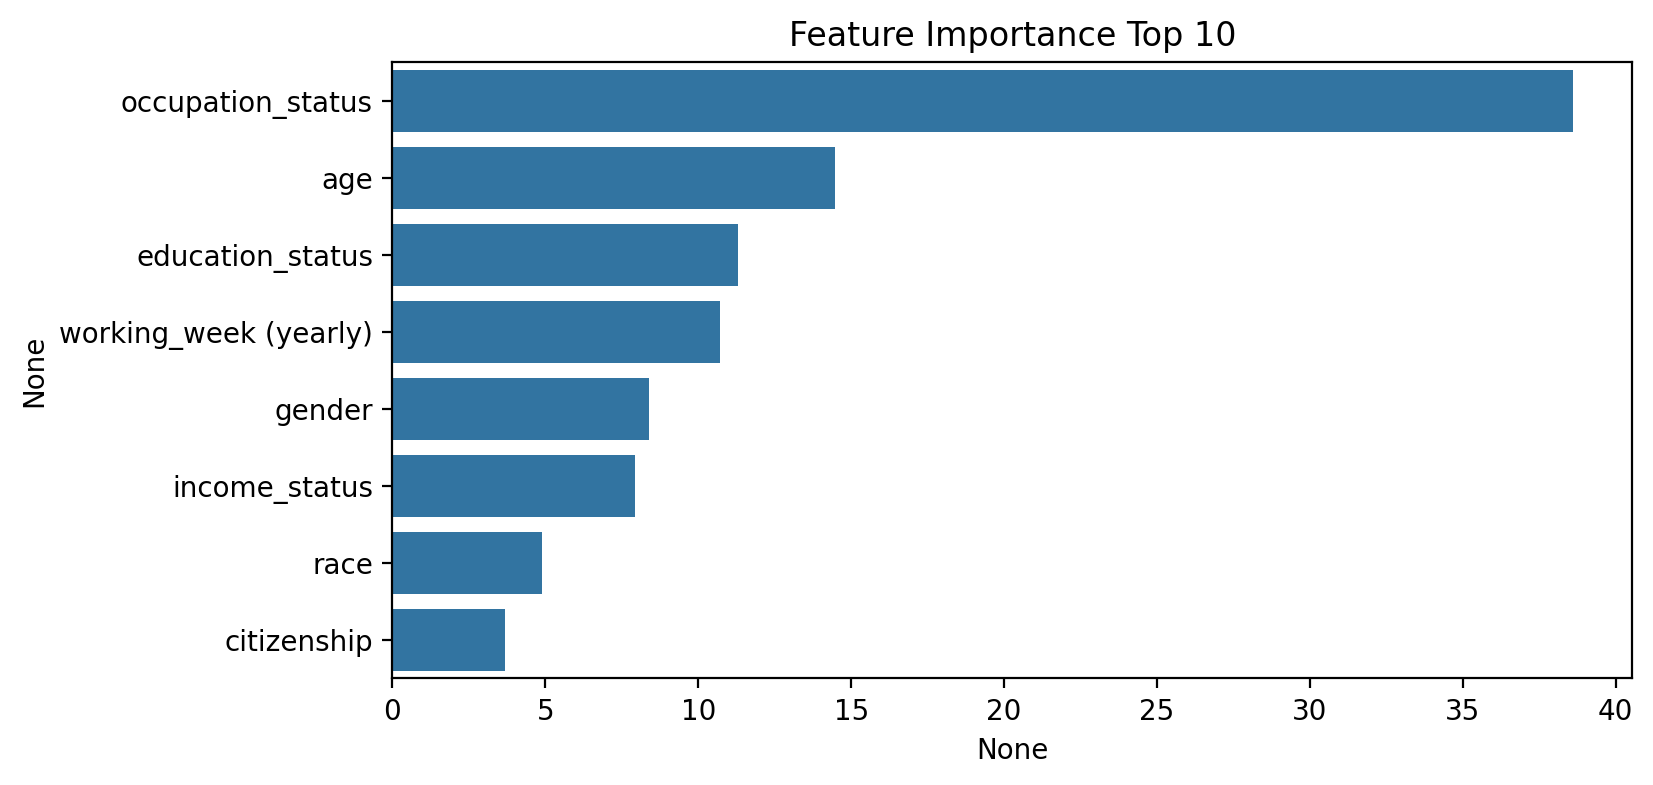

In [53]:
# feature importance 파악

# 배열형태로 반환
cat_importance_values = cat_optuna.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
cat_series = pd.Series(cat_importance_values, index = X_train.columns)
cat_top10 = cat_series.sort_values(ascending=False)[:10]

# 시각화
plt.figure(figsize=(8,4))
plt.title('Feature Importance Top 10')
sns.barplot(x=cat_top10, y=cat_top10.index)
plt.show()


# 이 지표는 절대적이지 않다.
# 중요도는 낮게 평가되었지만 실제로 중요한 특성일 수도 있고,
# 그렇기 때문에 제거했을 경우 성능이 떨어질 수도 있다.
# -> 상위 n개의 특성들을 제외한 나머지 특성들을 모두 제거하는 방식은 바람직하지 못함

# feature importance를 고려하여 특성별로 A/B test 를 진행하며 feature selection 해야 한다
# https://hwi-doc.tistory.com/entry/Feature-selection-feature-importance-vs-permutation-importance

In [54]:
y_test_cat = cat_optuna.predict(X_test_no_enc)
y_test_cat

array([ -5.38540711, -12.91841674, 451.91455191, ..., 496.43548275,
        -1.02763095, 625.39450107])

In [55]:
submission_df_cat = submission_df.copy()
submission_df_cat["Income"] = y_test_cat
submission_df_cat.head()

,ID,Income
0,TEST_0000,-5.385407
1,TEST_0001,-12.918417
2,TEST_0002,451.914552
3,TEST_0003,576.981205
4,TEST_0004,-7.759732


In [56]:
# 전처리 완료한 파일 csv로 저장
submission_df_cat.to_csv("data/submission_cat3.csv", index=False)

### LightGBM

In [57]:
lgbm_optuna.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 350
[LightGBM] [Info] Number of data points in the train set: 14000, number of used features: 8
[LightGBM] [Info] Start training from score 557.920714


LGBMRegressor(colsample_bytree=0.7233930021860604,
              learning_rate=0.0029342254653003737, min_data_in_leaf=47,
              n_estimators=1083, num_leaves=121, subsample=0.1894681671988927)

In [58]:
rmse_lgbm = metrics.mean_squared_error(y_val, lgbm_optuna.predict(X_val),squared=False)
rmse_lgbm

[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47


597.1122012898966

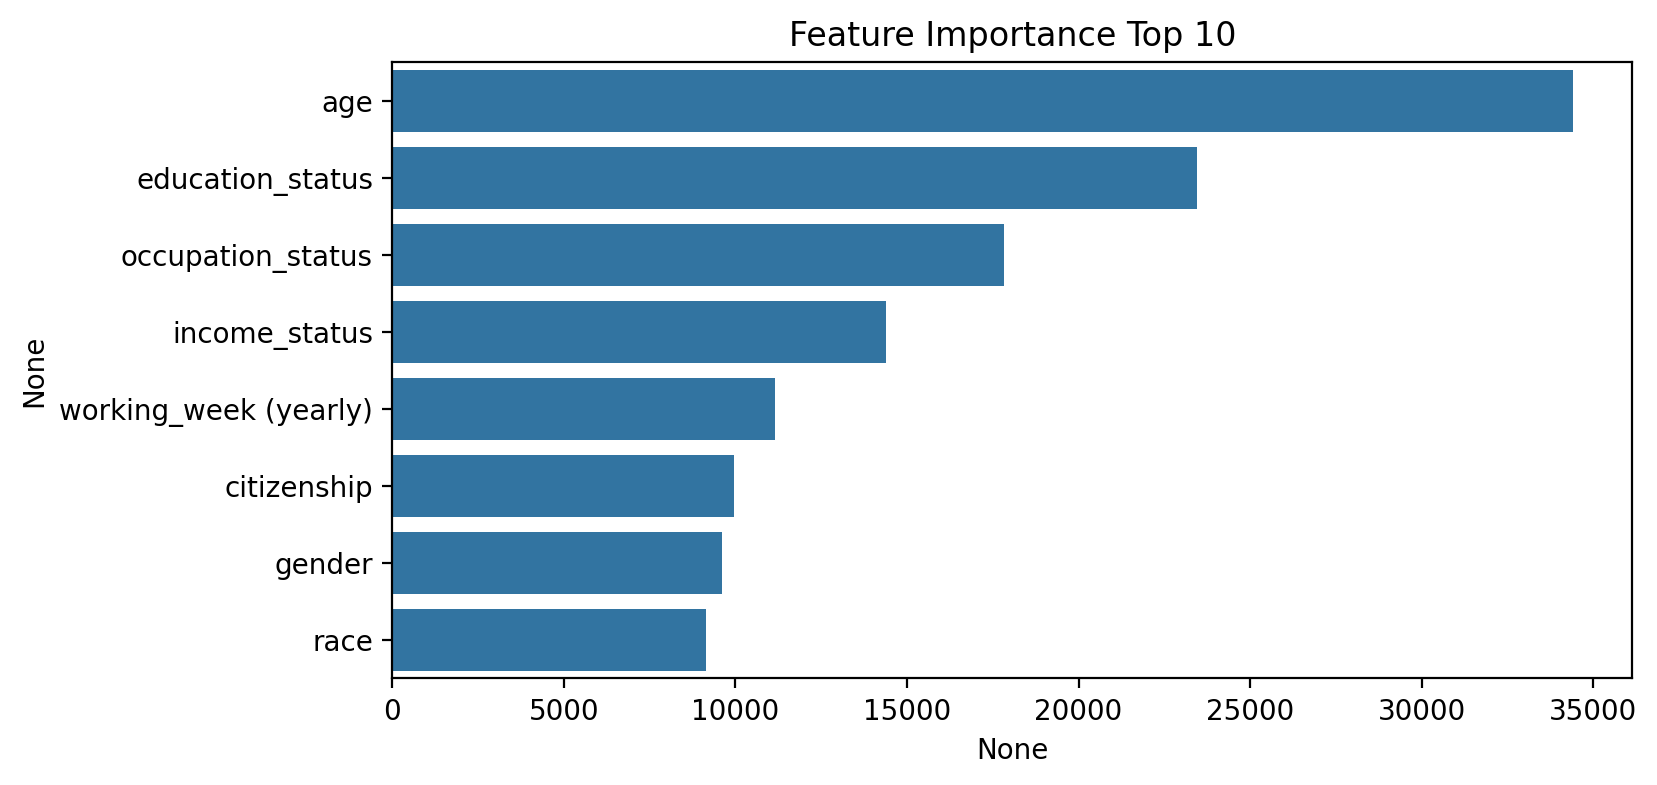

In [59]:
# feature importance 파악

# 배열형태로 반환
lgbm_importance_values = lgbm_optuna.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
lgbm_series = pd.Series(lgbm_importance_values, index = X_train.columns)
lgbm_top10 = lgbm_series.sort_values(ascending=False)[:10]

# 시각화
plt.figure(figsize=(8,4))
plt.title('Feature Importance Top 10')
sns.barplot(x=lgbm_top10, y=lgbm_top10.index)
plt.show()


# 이 지표는 절대적이지 않다.
# 중요도는 낮게 평가되었지만 실제로 중요한 특성일 수도 있고,
# 그렇기 때문에 제거했을 경우 성능이 떨어질 수도 있다.
# -> 상위 n개의 특성들을 제외한 나머지 특성들을 모두 제거하는 방식은 바람직하지 못함

# feature importance를 고려하여 특성별로 A/B test 를 진행하며 feature selection 해야 한다
# https://hwi-doc.tistory.com/entry/Feature-selection-feature-importance-vs-permutation-importance

In [60]:
y_test_lgbm = lgbm_optuna.predict(X_test)
y_test_lgbm

[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47


array([ 18.48452999,  25.28871977, 439.70451384, ..., 614.54133527,
        19.34220091, 577.54991959])

In [61]:
submission_df_lgbm = submission_df.copy()
submission_df_lgbm["Income"] = y_test_lgbm
submission_df.head()

,ID,Income
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,0
4,TEST_0004,0


In [62]:
# 전처리 완료한 파일 csv로 저장
submission_df_lgbm.to_csv("data/submission_lgbm3.csv", index=False)